In [1]:
#import os
#os.environ['KERAS_BACKEND'] = 'tensorflow'

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.utils import plot_model
from keras.layers import  LSTM, RepeatVector, TimeDistributed, Dropout
from sklearn import metrics
import seaborn as sns
from keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
data=pd.read_csv("Book.csv")

In [3]:
price=data['Price']

In [4]:
del data['Price']

In [5]:
del data['Time']

In [6]:
data.shape

(43956, 21)

In [7]:
def split_sequences(Xt,yt,step ,look_back, horizon):
    X, y = list(), list()
    for i in range(0,len(Xt),step):
        end_ix = i + look_back
        out_end_ix = end_ix + horizon-1
        if out_end_ix > len(Xt)-1:
            break
        seq_x, seq_y = Xt[i:end_ix], yt[out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    X,y=np.array(X), np.array(y)
    return X,y

In [8]:
def train_test_split(data,train_size=0.9,look_back = 128,horizon=15,step=50,scale=True):
    split_idx = int(data.shape[0]*train_size)
    data=data.values
    X_train = data[:split_idx, :-1]
    y_train = data[:split_idx, -1]
    X_test = data[split_idx:, :-1]
    y_test = data[split_idx:, -1]
    
    if scale:
        scalerX = StandardScaler().fit(X_train)
        X_train = scalerX.transform(X_train)
        X_test = scalerX.transform(X_test)
    
    X_train,y_train=split_sequences(X_train,y_train,step,look_back,horizon)
    X_test,y_test=split_sequences(X_test,y_test,step,look_back,horizon)

    

   
    
    
    return X_train,y_train,X_test,y_test

In [9]:
k=pd.DataFrame(np.arange(1,31).reshape((-1,3)))

In [10]:
a,b,c,d=train_test_split(k,0.9,3,2,2,False)

In [11]:
k

,0,1,2
0,1,2,3
1,4,5,6
2,7,8,9
3,10,11,12
4,13,14,15
5,16,17,18
6,19,20,21
7,22,23,24
8,25,26,27
9,28,29,30


In [12]:
a

array([[[ 1,  2],
        [ 4,  5],
        [ 7,  8]],

       [[ 7,  8],
        [10, 11],
        [13, 14]],

       [[13, 14],
        [16, 17],
        [19, 20]]])

In [13]:
b

array([15, 21, 27])

In [14]:
X_train,y_train,X_test,y_test=train_test_split(data,train_size=0.9,look_back = 50,horizon=5,step=1,scale=True)

In [15]:
label_train=y_train+1

In [16]:
label_test=y_test+1

(array([11186.,     0.,     0.,     0.,     0., 16837.,     0.,     0.,
            0., 11483.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

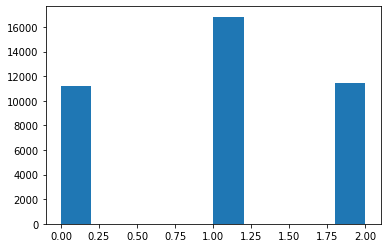

In [17]:
plt.hist(label_train)

(array([1535.,    0.,    0.,    0.,    0., 1275.,    0.,    0.,    0.,
        1532.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

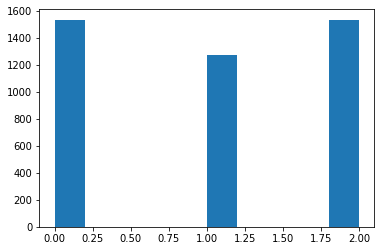

In [18]:
plt.hist(label_test)

In [19]:
y_train=to_categorical(label_train)

In [20]:
y_test=to_categorical(label_test)

In [21]:
#valsize=int(X_test.shape[0]*0.1)

In [22]:
#valx=X_test[:valsize]
#valy=y_test[:valsize]
#X_test=X_test[valsize:]
#y_test=y_test[valsize:]

In [23]:
X_train.shape

(39506, 50, 20)

In [24]:
y_train.shape

(39506, 3)

In [25]:
X_test.shape

(4342, 50, 20)

In [26]:
y_test.shape

(4342, 3)

In [27]:
input_shape=(X_train.shape[1],X_train.shape[2])

In [28]:
input_shape

(50, 20)

CNN_LSTM

In [29]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=input_shape))
model_cnn_lstm.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(100, activation='relu'))                                  
model_cnn_lstm.add(Dense(3,activation="softmax"))
model_cnn_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 49, 16)            656       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 32)            1056      
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 23,715
Trainable params: 23,715
Non-trainable params: 0
_________________________________________________________________


In [102]:
verbose, epochs, batch_size = 1,1000,1024
checkpoint="cnnlstm2.model"

early_stopping = EarlyStopping(patience=6, verbose=verbose,monitor='val_loss')
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.000001, verbose=verbose,monitor='loss')
model_checkpoint = ModelCheckpoint(checkpoint, save_best_only=True, verbose=verbose,monitor='val_accuracy')

In [103]:
opt=Adam(learning_rate=0.01)#'categorical_crossentropy'CategoricalAccuracy()
model_cnn_lstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history_cnnlstm=model_cnn_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,verbose=verbose, validation_data=(X_test,y_test),callbacks=[early_stopping,model_checkpoint, reduce_lr])

Train on 39506 samples, validate on 4342 samples
Epoch 1/1000
39506/39506 [==============================] - 17s 420us/step - loss: 1.0902 - accuracy: 0.4235 - val_loss: 1.1235 - val_accuracy: 0.2936

Epoch 00001: val_accuracy improved from -inf to 0.29364, saving model to cnnlstm2.model
Epoch 2/1000
39506/39506 [==============================] - 14s 366us/step - loss: 1.1017 - accuracy: 0.4273 - val_loss: 1.1240 - val_accuracy: 0.2936

Epoch 00002: val_accuracy did not improve from 0.29364
Epoch 3/1000
39506/39506 [==============================] - 15s 368us/step - loss: 1.0746 - accuracy: 0.4296 - val_loss: 1.1243 - val_accuracy: 0.2939

Epoch 00003: val_accuracy improved from 0.29364 to 0.29387, saving model to cnnlstm2.model
Epoch 4/1000
39506/39506 [==============================] - 15s 369us/step - loss: 1.0676 - accuracy: 0.4397 - val_loss: 1.1026 - val_accuracy: 0.3614

Epoch 00004: val_accuracy improved from 0.29387 to 0.36135, saving model to cnnlstm2.model
Epoch 5/1000
39506

39506/39506 [==============================] - 15s 376us/step - loss: 0.9464 - accuracy: 0.5429 - val_loss: 0.9255 - val_accuracy: 0.5334

Epoch 00038: val_accuracy improved from 0.53017 to 0.53339, saving model to cnnlstm2.model
Epoch 39/1000
39506/39506 [==============================] - 15s 371us/step - loss: 0.9444 - accuracy: 0.5453 - val_loss: 0.9326 - val_accuracy: 0.5251

Epoch 00039: val_accuracy did not improve from 0.53339
Epoch 40/1000
39506/39506 [==============================] - 15s 386us/step - loss: 0.9407 - accuracy: 0.5461 - val_loss: 0.9209 - val_accuracy: 0.5302

Epoch 00040: val_accuracy did not improve from 0.53339
Epoch 41/1000
39506/39506 [==============================] - 15s 369us/step - loss: 0.9405 - accuracy: 0.5485 - val_loss: 0.9238 - val_accuracy: 0.5302

Epoch 00041: val_accuracy did not improve from 0.53339
Epoch 42/1000
39506/39506 [==============================] - 14s 365us/step - loss: 0.9416 - accuracy: 0.5468 - val_loss: 0.9266 - val_accuracy: 0

In [106]:
cnls1=pd.DataFrame(history_cnnlstm.history)
cnls1.to_csv("cnnlstmhistory53.csv")

<IPython.core.display.Javascript object>


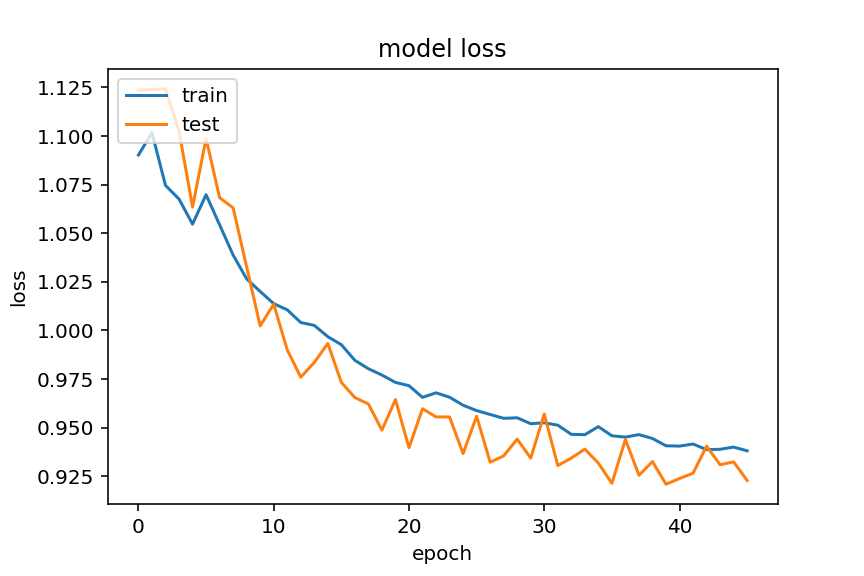

In [109]:
%matplotlib notebook
plt.plot(history_cnnlstm.history['loss'])
plt.plot(history_cnnlstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


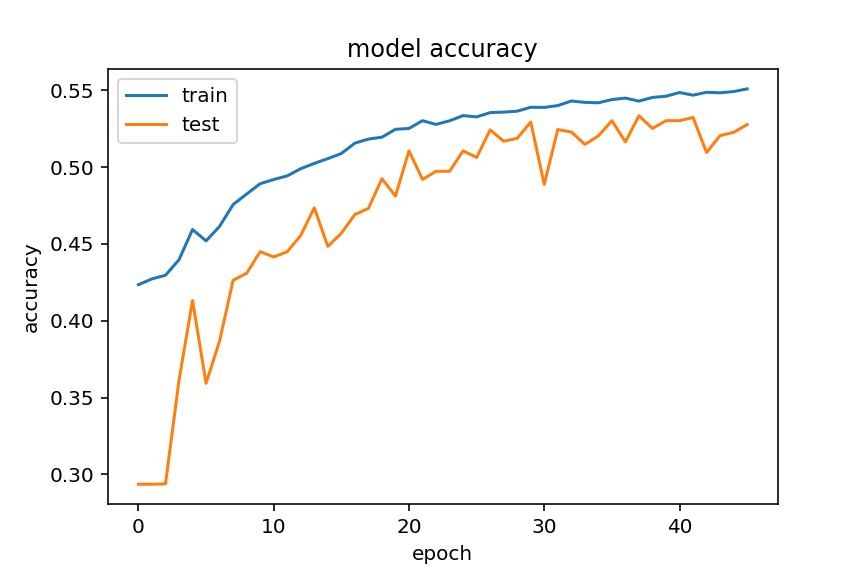

In [108]:
%matplotlib notebook
plt.plot(history_cnnlstm.history['accuracy'])
plt.plot(history_cnnlstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

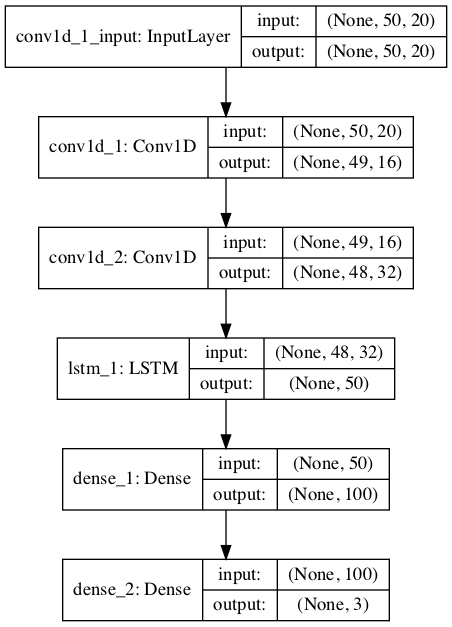

In [82]:
plot_model(model_cnn_lstm,to_file='model_cnn_lstm.png',show_shapes=True)

In [80]:
model_cnn_lstm.load_weights("cnnlstmcount1.model")

In [82]:
verbose, epochs, batch_size = 1,1000,2048
checkpoint="cnnlstmcount1.model"

early_stopping = EarlyStopping(patience=6, verbose=verbose,monitor='loss')
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.000001, verbose=verbose,monitor='loss')
model_checkpoint = ModelCheckpoint(checkpoint, save_best_only=True, verbose=verbose,monitor='val_accuracy')

In [90]:
opt=Adam(lr=0.01)#'categorical_crossentropy'CategoricalAccuracy()early_stopping,, reduce_lr
model_cnn_lstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history_cnnlstm=model_cnn_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,verbose=verbose, validation_data=(X_test,y_test),callbacks=[model_checkpoint])

Train on 39506 samples, validate on 4342 samples
Epoch 1/1000
39506/39506 [==============================] - 13s 336us/step - loss: 0.8834 - accuracy: 0.5811 - val_loss: 0.9495 - val_accuracy: 0.5242

Epoch 00001: val_accuracy did not improve from 0.53178
Epoch 2/1000
39506/39506 [==============================] - 11s 276us/step - loss: 0.8673 - accuracy: 0.5904 - val_loss: 0.9656 - val_accuracy: 0.5253

Epoch 00002: val_accuracy did not improve from 0.53178
Epoch 3/1000
39506/39506 [==============================] - 12s 298us/step - loss: 0.8562 - accuracy: 0.5950 - val_loss: 0.9598 - val_accuracy: 0.5274

Epoch 00003: val_accuracy did not improve from 0.53178
Epoch 4/1000
 6144/39506 [===>..........................] - ETA: 9s - loss: 0.8334 - accuracy: 0.6100

KeyboardInterrupt: 

In [69]:
model_cnn_lstm.save_weights("CNNLSTM538.model")

LAST MODEL

In [30]:
model_cnn_lstm.load_weights("cnnlstmcount.model")
opt=Adam(learning_rate=0.01)
model_cnn_lstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_cnn_lstm.evaluate(X_test, y_test,verbose=0)[1]

0.5384615659713745

In [31]:
ac=model_cnn_lstm.evaluate(X_test, y_test,verbose=0)[1]
print("CNN_LSTM model accuracy:" +str(ac))

CNN_LSTM model accuracy:0.5384615659713745


In [32]:
predcnnlstm=model_cnn_lstm.predict_classes(X_test)

<IPython.core.display.Javascript object>


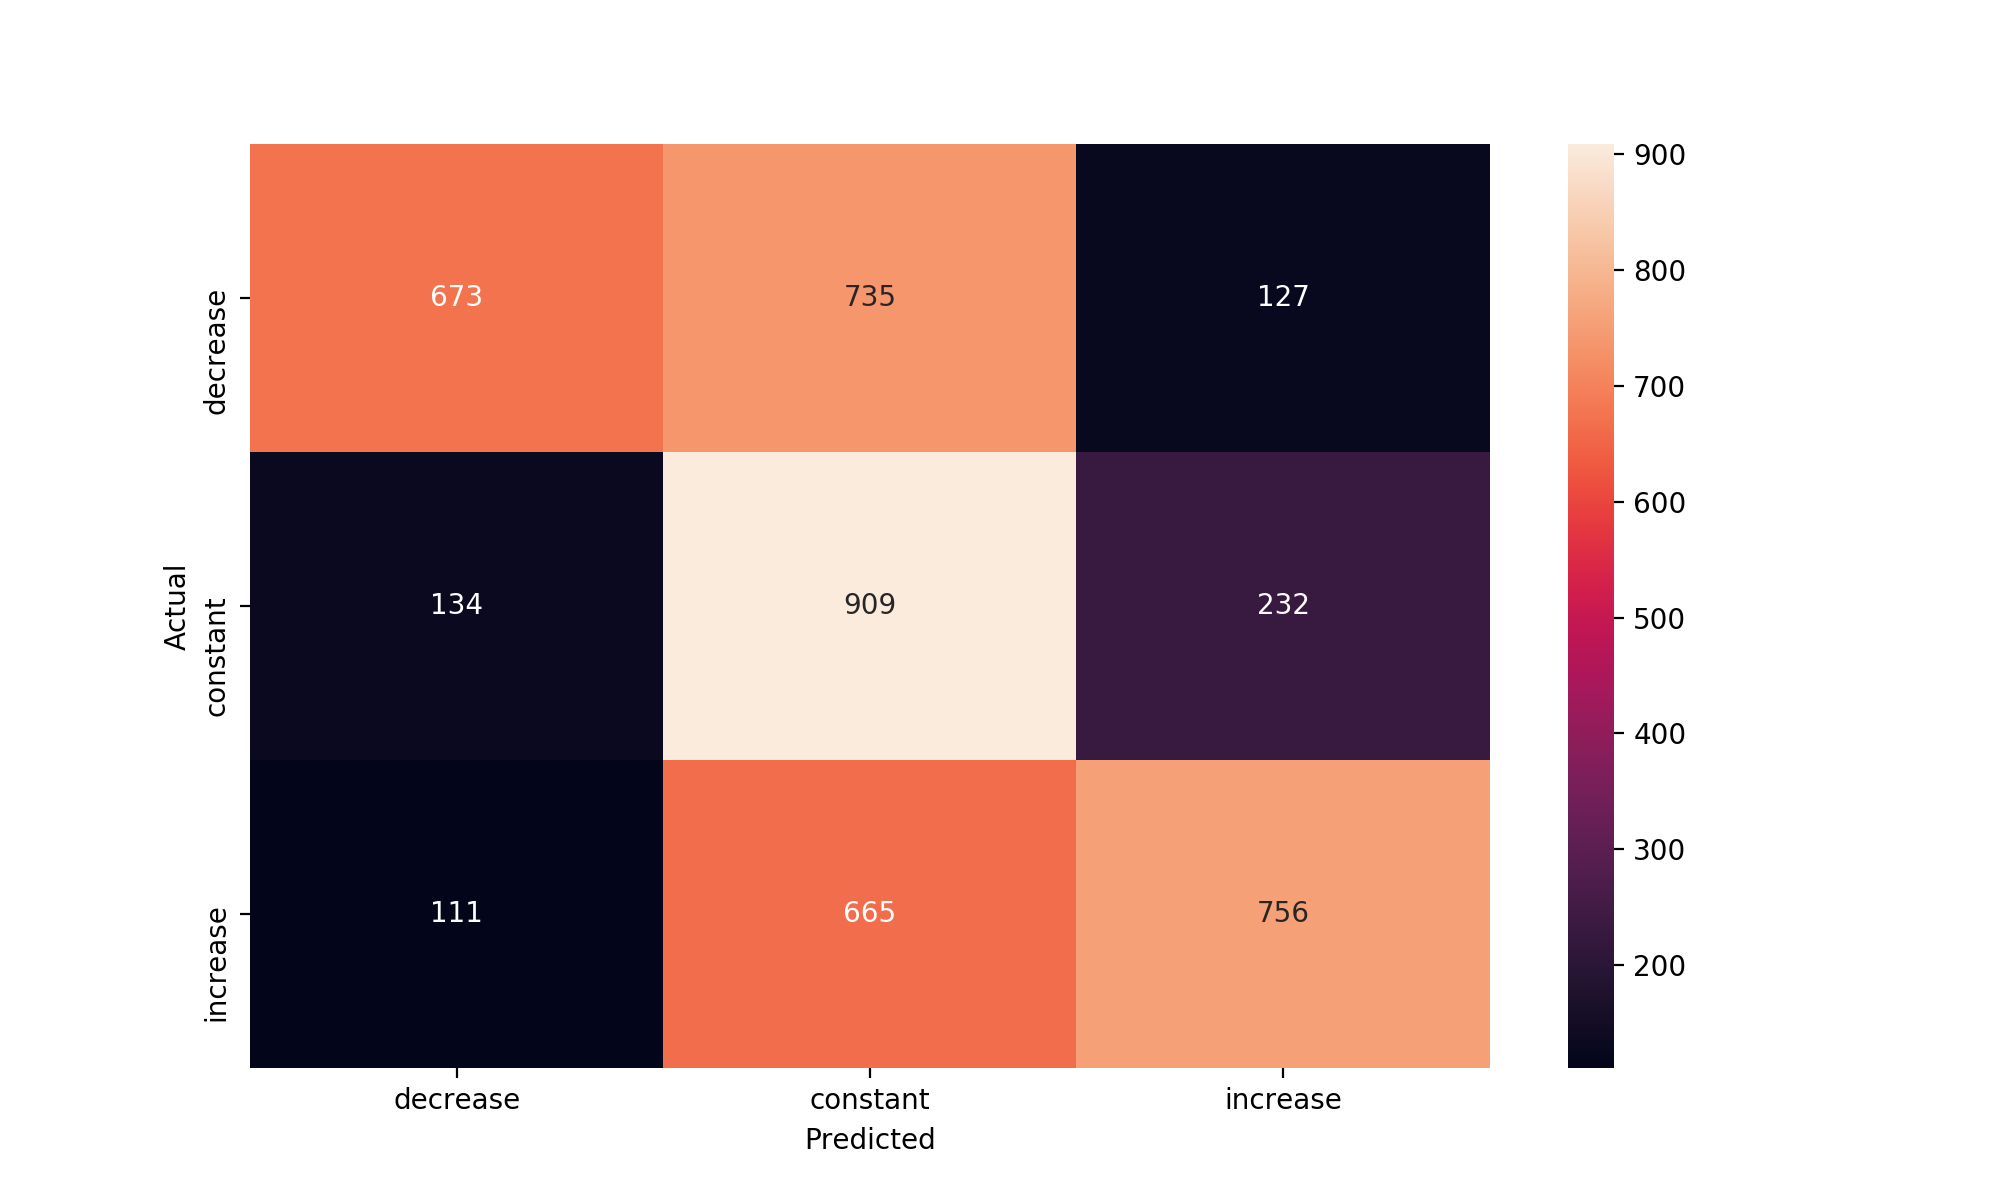

In [33]:
%matplotlib notebook
cm =confusion_matrix(label_test, predcnnlstm)  
index = ['decrease','constant','increase']  
columns = ['decrease','constant','increase']   
cm_df = pd.DataFrame(cm,columns,index) 
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True,fmt="d")

In [36]:
print(classification_report(label_test, predcnnlstm,target_names=['decrease','constant','increase']))

              precision    recall  f1-score   support

    decrease       0.73      0.44      0.55      1535
    constant       0.39      0.71      0.51      1275
    increase       0.68      0.49      0.57      1532

    accuracy                           0.54      4342
   macro avg       0.60      0.55      0.54      4342
weighted avg       0.61      0.54      0.54      4342

